In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import itertools

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [331]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measuredf = pd.DataFrame(pd.read_csv("Resources/hawaii_measurements.csv"))
# Calculate the date 1 year ago from the last data point in the database
stationdf = pd.DataFrame(pd.read_csv("Resources/hawaii_stations.csv"))
# Perform a query to retrieve the data and precipitation scores
df = measuredf.merge(stationdf, on = "station")
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

start_date = "2016-01-01"
end_date = "2017-01-01"
stationdf

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [262]:
# created a class for precipitation data, with callable objects and functions to make everything for 
#precipitation related data in one place

class precipitation:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
    def dates(self):
        date1 =  session.query(Measurement.date).order_by(Measurement.date).filter(Measurement.date >= self.start_date).\
        filter(Measurement.date <= self.end_date).distinct()
        return [date[0] for date in date1]
    def prcp(self):
        #takes average temperature from all the station readings for that particular date
        prlist = []
        for d in precipitation.dates(self):
            prlist.append(session.query(func.avg(Measurement.prcp)).\
                          filter(Measurement.date == d).all())
        return [pr[0][0] for pr in prlist]
    def maxPrcp(self):
        return session.query(func.max(Measurement.prcp)).filter(Measurement.date >= self.start_date).filter(Measurement.date <= self.end_date).all()[0][0]
    def minPrcp(self):
        return session.query(func.min(Measurement.prcp)).filter(Measurement.date >= self.start_date).filter(Measurement.date <= self.end_date).all()[0][0]
    def avgPrcp(self):
        #average precipitation over all stations over given time frame
        return session.query(func.avg(Measurement.prcp)).filter(Measurement.date >= self.start_date).filter(Measurement.date <= self.end_date).all()
    
    #this is for later on in the code. 
    def stationPrcp(self):
        stations = session.query(Measurement.station).distinct()
        stations = [station[0] for station in stations]
        stationDict = {}
        
        for station in stations:
            rainDict = []
            for date in precipitation.dates(self):  
                data = session.query(Measurement.prcp).filter(Measurement.date == date).\
                filter(Measurement.station == station).all()
                if(len(data) == 0):
                    rainDict.append(0.0)
                else:
                    rainDict.append(data[0][0])                     
            rainDict = [0 if v is None else v for v in rainDict ]
            stationDict[station] = rainDict
            
        return stationDict



In [263]:
rainData = precipitation(start_date, end_date)
dateList = rainData.dates()
prcpList = rainData.prcp()
prcpList = [0 if v is None else v for v in prcpList ]
raindf = pd.DataFrame({"Average Precipitation Level": prcpList}, index = dateList)



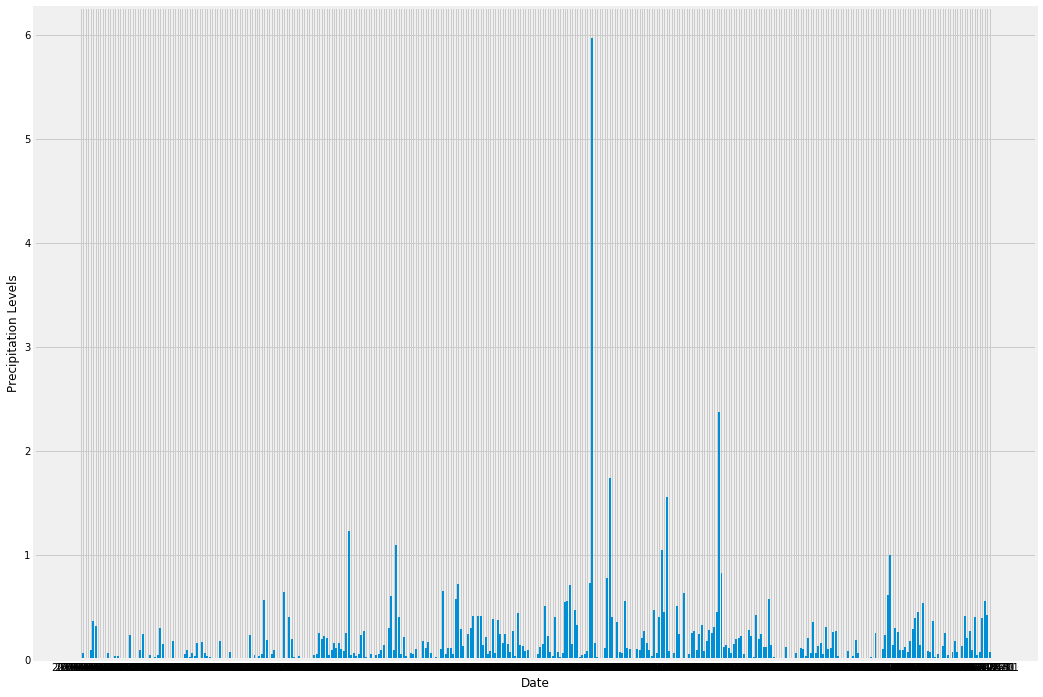

In [265]:

fig, ax = plt.subplots(figsize = (16, 12))
ax.bar(dateList, prcpList, width = 0.8)
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation Levels")
plt.show()

![precipitation](Images/precipitation.png)


In [62]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df["prcp"].describe()


count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [363]:
# Design a query to show how many stations are available in this dataset?
stationSet = session.query(func.count(Station.station)).all()[0][0]
stationSet

9

In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationcount = pd.DataFrame(df["station"].value_counts())
stationcount.sort_values(by = "station", ascending = False)


,station
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [367]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stationcount.reset_index(inplace = True)
popStation = stationcount["index"][0]


'USC00519281'

In [370]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns("station")


![precipitation](Images/station-histogram.png)

In [277]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

class calc_temps:
    
    """To make things overall a bit easier, I just created a class for tempData, so that way there's less typing in later cells
    """
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
    def dateList(self):
        dates = session.query(Measurement.date).filter(Measurement.date >= self.start_date).filter(Measurement.date <= self.end_date).distinct()
        return [date[0] for date in dates]
    def minTemp(self):
        return session.query(func.min(Measurement.tobs)).filter(Measurement.date >= self.start_date).filter(Measurement.date <= self.end_date).all()
    def maxTemp(self):
        return session.query(func.max(Measurement.tobs)).filter(Measurement.date >= self.start_date).filter(Measurement.date <= self.end_date).all()
    def avgTemp(self):
        return session.query(func.avg(Measurement.tobs)).filter(Measurement.date >= self.start_date).filter(Measurement.date <= self.end_date).all()
    def tempData(self):
        #average temperature across all stations
        temp = []
        for date in calc_temps.dateList(self):
            temp.append(session.query(func.avg(Measurement.tobs)).filter(Measurement.date == date).all()[0][0])
        return temp
    
    def tempStats(self):    
        stations = session.query(Measurement.station).distinct()
        stations = [station[0] for station in stations]
        stationDict = {}       
        for station in stations:
            tempDict = []
            for date in calc_temps.dateList(self):  
                data = session.query(Measurement.tobs).filter(Measurement.date == date).\
                filter(Measurement.station == station).all()
                if(len(data) == 0):
                    tempDict.append(0.00)
                else:
                    tempDict.append(data[0][0])                     
            tempDict = [0 if v is None else v for v in tempDict ]
            stationDict[station] = tempDict            
        return stationDict
    def stationAverages(self):
        stations = session.query(Measurement.station).distinct()
        stations = [station[0] for station in stations]
        stationDict = {}       
        for station in stations:
            tempDict = []  
            data = session.query(func.avg(Measurement.prcp)).filter(Measurement.date >= self.start_date).\
            filter(Measurement.date <= self.end_date).filter(Measurement.station == station).all()
            if(len(data) == 0):
                tempDict.append(0.00)
            else:
                tempDict.append(data[0][0])                     
            tempDict = [0 if v is None else v for v in tempDict]
    

In [284]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
date1 = "-02-28"
date2 = "-03-14"
temp = calc_temps("2017" + date1, "2017" + date2)
x_date = temp.dateList()
y_temp = temp.tempData()
y_err = temp.maxTemp()[0][0]- temp.minTemp()[0][0]

temperatures = pd.DataFrame(temp.tempStats(), index = x_date)
temperatures["Average"] = y_temp
temperatures

,USC00519397,USC00513117,USC00514830,USC00517948,USC00518838,USC00519523,USC00519281,USC00511918,USC00516128,Average
2017-02-28,74.0,73.0,73.0,72.0,0.0,73.0,72.0,0.0,69.0,72.285714
2017-03-01,66.0,72.0,71.0,66.0,0.0,73.0,71.0,0.0,64.0,69.000000
2017-03-02,73.0,73.0,0.0,73.0,0.0,75.0,73.0,0.0,72.0,73.166667
2017-03-03,69.0,73.0,73.0,70.0,0.0,74.0,72.0,0.0,78.0,72.714286
2017-03-04,74.0,76.0,0.0,0.0,0.0,77.0,77.0,0.0,70.0,74.800000
2017-03-05,71.0,70.0,0.0,0.0,0.0,0.0,73.0,0.0,68.0,70.500000
2017-03-06,69.0,66.0,74.0,67.0,0.0,69.0,67.0,0.0,76.0,69.714286
2017-03-07,68.0,65.0,74.0,67.0,0.0,0.0,62.0,0.0,72.0,68.000000
2017-03-08,71.0,70.0,74.0,67.0,0.0,0.0,64.0,0.0,68.0,69.000000
2017-03-09,72.0,67.0,69.0,68.0,0.0,70.0,67.0,0.0,72.0,69.285714


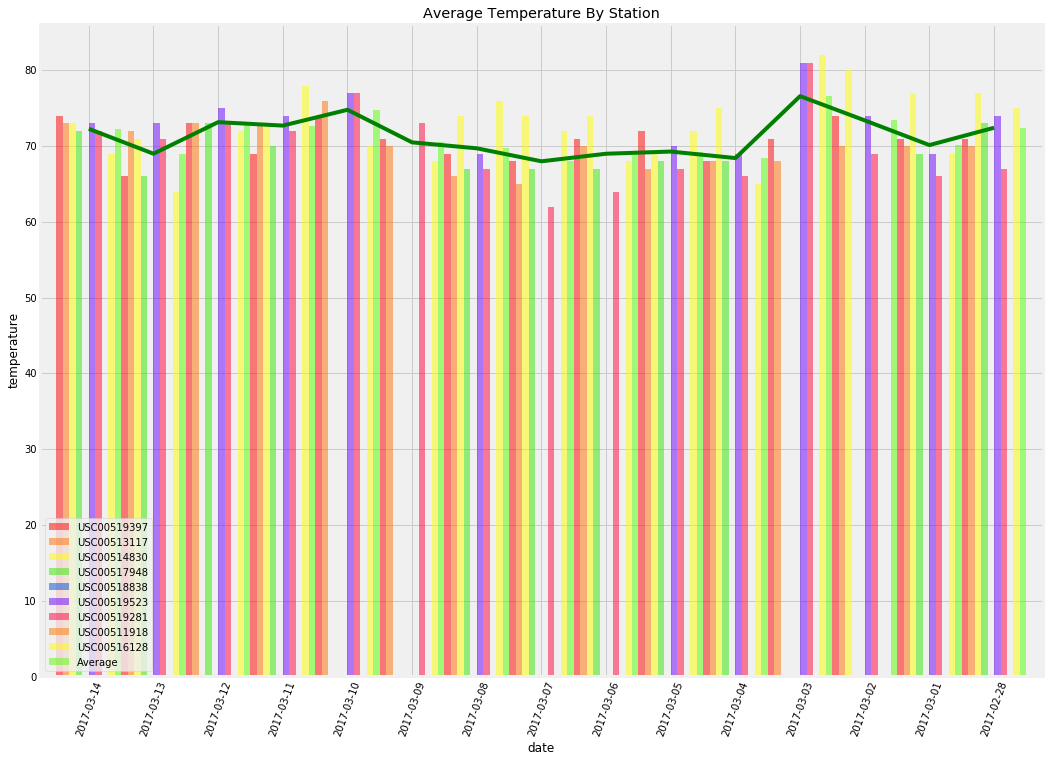

In [289]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
ax.plot(x_date, temperatures["Average"], color = "green")
temperatures.plot(ax = ax, kind = "bar", colormap = "prism", alpha = .5, figsize = (16,12), width = 1)
ax.set_xlabel("date")
ax.set_ylabel("temperature")
ax.set_title("Average Temperature By Station")
ax.set_xticks(np.arange(0,len(x_date)))
ax.set_xticklabels(x_date[::-1], rotation = 70)
plt.show()


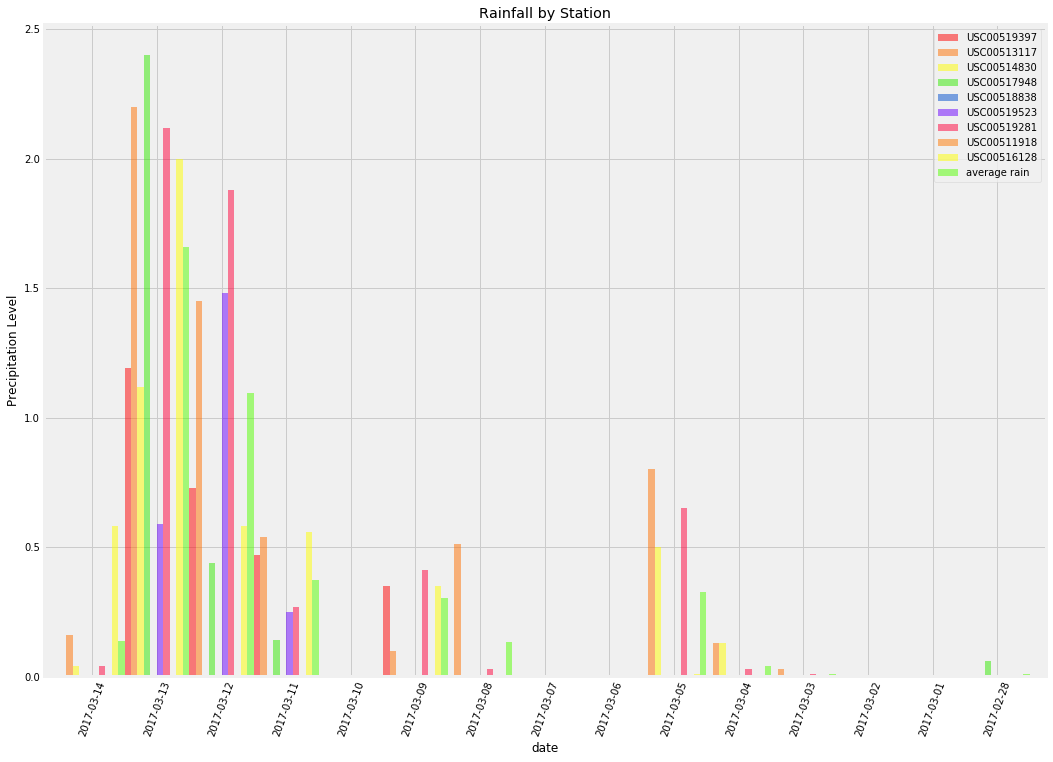

In [292]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainData = precipitation("2017" + date1, "2017" + date2)
dates = rainData.dates()
stationRain = rainData.stationPrcp()
stationRain = pd.DataFrame(stationRain, index = dates)
stationRain["average rain"] = rainData.prcp()

#average rainfall by station

markers = itertools.cycle(('^', '+', '.', 'o', '*', 'x', '1', 'v', '$*$', 's')) 

fig, ax = plt.subplots()
ddd.plot(ax = ax, kind = "bar", colormap = "prism", alpha = .5, figsize = (16,12), width = 1)
for i, line in enumerate(ax.get_lines()):
    line.set_marker(next(markers))
ax.set_xlabel("date")
ax.set_ylabel("Precipitation Level")
ax.set_title("Rainfall by Station")
ax.set_xticks(np.arange(0,len(x_date)))
ax.set_xticklabels(x_date[::-1], rotation = 70)
plt.show()

In [358]:
#dataframe of each station, location, and average rainfall for given vacation timeframe

stations = session.query(Station.station).distinct()
stations = [station[0] for station in stations]
rainDict = {}
start = "2017" + date1
end = "2017" + date2

rainAvg = []
nameList = []
longitudes = []
latitudes = []
altitudes = []
maxnum = []
minnum = []
for station in stations:     
    
    data = session.query(func.avg(Measurement.prcp)).filter(Measurement.date >= start).\
    filter(Measurement.date <= end).filter(Measurement.station == station).all()
    
    nameList.append(session.query(Station.name).filter(Station.station == station).all()[0][0])
    longitudes.append(session.query(Station.longitude).filter(Station.station == station).all()[0][0])
    latitudes.append(session.query(Station.latitude).filter(Station.station == station).all()[0][0])
    altitudes.append(session.query(Station.elevation).filter(Station.station == station).all()[0][0])
    
    maxnum.append(session.query(func.max(Measurement.station)).filter(Measurement.date >= start).\
    filter(Measurement.date <= end).filter(Measurement.station == station).all())
    
    minnum.append(session.query(Measurement.station).filter(Measurement.date >= start).\
    filter(Measurement.date <= end).filter(Measurement.station == station).all()))
    
    if(len(data) == 0 or data[0][0] is None):
        rainAvg.append(0.00)
    else:
        rainAvg.append(data[0][0])
rainDict["Average Prcp"] = rainAvg    
rainStats = pd.DataFrame(rainDict, index = stations)
rainStats["Station Name"] = nameList
rainStats["Longitude"] = longitudes
rainStats["Altitude"] = altitudes
rainStats.sort_values(by = "Average Prcp", ascending = False, inplace = True)

rainStats


,Average Prcp,Station Name,Longitude,Altitude
USC00517948,0.506667,"PEARL CITY, HI US",-157.97510,11.9
USC00513117,0.394667,"KANEOHE 838.1, HI US",-157.80150,14.6
USC00519281,0.362667,"WAIHEE 837.5, HI US",-157.84889,32.9
USC00516128,0.313846,"MANOA LYON ARBO 785.2, HI US",-157.80250,152.4
USC00519523,0.232000,"WAIMANALO EXPERIMENTAL FARM, HI US",-157.71139,19.5
USC00514830,0.223750,"KUALOA RANCH HEADQUARTERS 886.9, HI US",-157.83740,7.0
USC00519397,0.182667,"WAIKIKI 717.2, HI US",-157.81680,3.0
USC00518838,0.000000,"UPPER WAHIAWA 874.3, HI US",-158.01110,306.6
USC00511918,0.000000,"HONOLULU OBSERVATORY 702.2, HI US",-157.99920,0.9


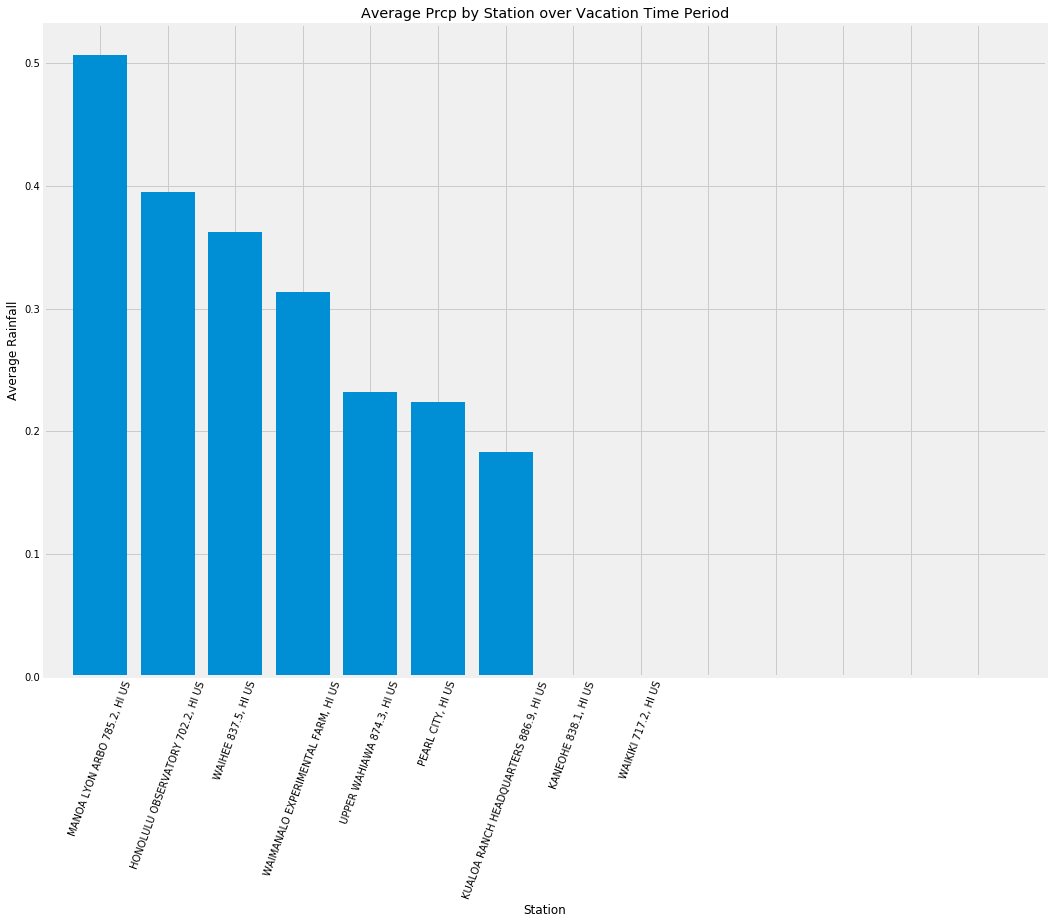

In [359]:

fig, ax = plt.subplots(figsize = (16,12))
ax.bar(nameList, rainStats["Average Prcp"])
ax.set_xlabel("Station")
ax.set_ylabel("Average Rainfall")
ax.set_title("Average Prcp by Station over Vacation Time Period")
ax.set_xticks(np.arange(0,len(x_date)))
ax.set_xticklabels(nameList[::-1], rotation = 70)
plt.show()


In [344]:
tempList1 = calc_temps("2012" + date1, "2012" + date2).tempData()
tempList2 = calc_temps("2013" + date1, "2013" + date2).tempData()
tempList3 = calc_temps("2014" + date1, "2014" + date2).tempData()
tempList4 = calc_temps("2015" + date1, "2015" + date2).tempData()
tempList5 = calc_temps("2016" + date1, "2016" + date2).tempData()
tempList1 = [tempList1[i] for i in range(0, len(tempList2))]
tempList5 = [tempList5[i] for i in range(0, len(tempList2))]
tempTable = pd.DataFrame({"2013": tempList2, "2014": tempList3, "2015":tempList4, "2016": tempList5, "2017": y_temp}).astype("float")

tempTable["average"] = (tempTable["2017"] + tempTable["2013"] + tempTable["2015"] + tempTable["2014"])/4
tempTable["date"] = x_date
tempTable.set_index("date", inplace = True)


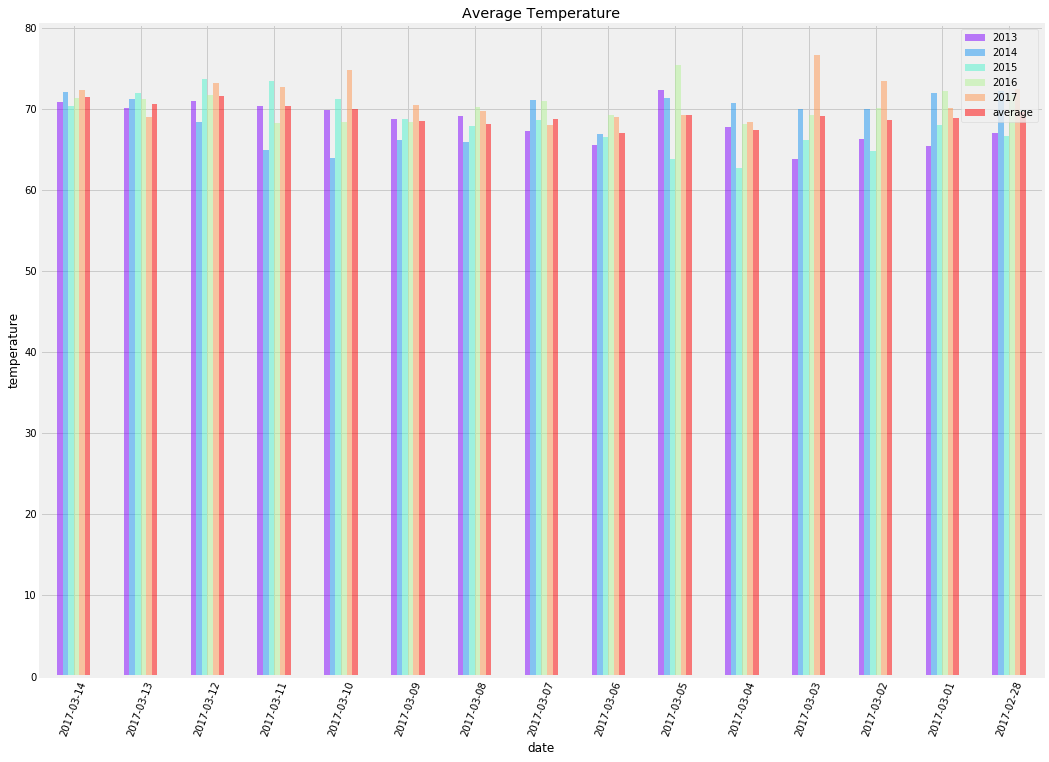

In [347]:
#average temperature taken from past four years. Plotted along the date timeframe of the vacation


markers = itertools.cycle(('^', '+', '.', 'o', '*', 'x', '1', 'v', '$*$', 's')) 

fig, ax = plt.subplots(figsize = (16,12))
tempTable.plot(ax = ax, kind = "bar", colormap = "rainbow", alpha = .5)
for i, line in enumerate(ax.get_lines()):
    line.set_marker(next(markers))
ax.set_xlabel("date")
ax.set_ylabel("temperature")
ax.set_title("Average Temperature")
ax.set_xticks(np.arange(0,len(x_date)))
ax.set_xticklabels(x_date[::-1], rotation = 70)
plt.show()

## Optional Challenge Assignment

In [371]:
# Plot the daily normals as an area plot with `stacked=False`
session.close()